In [76]:
#from google.colab import drive
#drive.mount('/content/drive')

In [77]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.layers import Input, Dense, Dropout
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import os
import shutil

In [78]:
# Load NASDAQ 100 data - Colab
# nasdaq100_data = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/datasets/nasdaq100.pkl')

# Load NASDAQ 100 data - Local
nasdaq100_data = pd.read_pickle(r'C:\aiprojects\gbc-projects\DL1_Financial\AASD4010_project\data\data_pkls\nasdaq100.pkl')

In [79]:
nasdaq100_data.shape

(15618, 606)

Data Pre-Processing (With PCT)

In [80]:
# Getting only 'Adj Close' column for each company

df = pd.DataFrame()

# Loop through each company
for company in nasdaq100_data.columns.levels[0]:
    company_data = nasdaq100_data[company]

    # Calculate daily returns, volatility, and average return for each company
    daily_returns = company_data['Adj Close'].pct_change()
    volatility = daily_returns.rolling(window=20).std()
    # average_return = daily_returns.rolling(window=20).mean()

    company_features = pd.DataFrame({
        f'{company}': volatility,
        # f'{company}_AverageReturn': average_return
    })

    df = pd.concat([df, company_features], axis=1)

df = df['2010':'2020']

In [81]:
df.head()

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,TTD,TTWO,TXN,VRSK,VRTX,WBA,WBD,WDAY,XEL,ZS
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.017053,NaN,0.013439,0.007235,0.007713,0.018346,0.008951,0.012732,0.025428,0.011336,...,NaN,0.073092,0.013778,0.012847,0.016888,0.013368,0.011084,NaN,0.008068,NaN
2010-01-05,0.016378,NaN,0.013574,0.007225,0.007295,0.016219,0.009190,0.012530,0.024472,0.011491,...,NaN,0.025075,0.013270,0.011810,0.018434,0.013459,0.014176,NaN,0.008435,NaN
2010-01-06,0.015836,NaN,0.013548,0.007095,0.007197,0.016049,0.008971,0.012437,0.018060,0.011525,...,NaN,0.025351,0.013240,0.011893,0.018764,0.013514,0.014493,NaN,0.008246,NaN
2010-01-07,0.015924,NaN,0.014207,0.007144,0.005744,0.015887,0.009130,0.012812,0.018198,0.011499,...,NaN,0.025477,0.013100,0.011815,0.018862,0.013141,0.014055,NaN,0.008320,NaN
2010-01-08,0.013435,NaN,0.014181,0.007010,0.005284,0.015085,0.009281,0.014998,0.018304,0.011647,...,NaN,0.025170,0.013819,0.012339,0.019420,0.010932,0.013702,NaN,0.008192,NaN


In [82]:
def clean_data(df):
    # Dropping completely empty columns
    empty_columns = df.columns[df.isnull().all()]
    df_cleaned = df.drop(empty_columns, axis=1)
    # Filling NaN values with mean
    imputer = SimpleImputer(strategy='mean')
    imputer.fit(df_cleaned)
    df_cleaned = imputer.transform(df_cleaned)   
    return df_cleaned, empty_columns

df_cleaned, empty_columns = clean_data(df)

In [83]:
def scale_data(df_cleaned):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df_cleaned)
    return df_scaled

df_scaled = scale_data(df_cleaned)

In [84]:
df_scaled.shape

(2769, 96)

In [85]:
# Autoencoder architecture - Without PCT
input_dim = df_scaled.shape[0] # The number of columns in the training data which is 192
encoding_dim = 2  # Set the desired dimensionality of the embeddings

# Reshape the input data
input_data = df_scaled.reshape(df_scaled.shape[1], 1, df_scaled.shape[0])

# Print the shape of the reshaped data
print(input_data.shape)


(96, 1, 2769)


In [86]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Encoder
encoder_inputs = Input(shape=(None, input_dim))
encoder = LSTM(100, return_sequences=True)(encoder_inputs)
encoder = LSTM(encoding_dim)(encoder)

# Decoder
decoder_inputs = RepeatVector(input_dim)(encoder)
decoder = LSTM(100, return_sequences=True)(decoder_inputs)
decoder_outputs = TimeDistributed(Dense(input_dim, activation='tanh'))(decoder)

# Autoencoder model
autoencoder = Model(inputs=encoder_inputs, outputs=decoder_outputs)

autoencoder.compile(optimizer=optimizer, loss='mse')

In [87]:
autoencoder.fit(input_data, input_data, epochs=50, batch_size=32, shuffle=True)

Epoch 1/50
3/3 [==============================] - 55s 10s/step - loss: 0.0547
Epoch 2/50
3/3 [==============================] - 14s 5s/step - loss: 0.0527
Epoch 3/50
3/3 [==============================] - 15s 5s/step - loss: 0.0469
Epoch 4/50
3/3 [==============================] - 15s 5s/step - loss: 0.0339
Epoch 5/50
3/3 [==============================] - 15s 5s/step - loss: 0.0252
Epoch 6/50
3/3 [==============================] - 15s 5s/step - loss: 0.0215
Epoch 7/50
3/3 [==============================] - 15s 5s/step - loss: 0.0194
Epoch 8/50
3/3 [==============================] - 15s 5s/step - loss: 0.0198
Epoch 9/50
3/3 [==============================] - 15s 5s/step - loss: 0.0194
Epoch 10/50
3/3 [==============================] - 15s 5s/step - loss: 0.0196
Epoch 11/50
3/3 [==============================] - 15s 5s/step - loss: 0.0192
Epoch 12/50
3/3 [==============================] - 15s 5s/step - loss: 0.0185
Epoch 13/50
3/3 [==============================] - 15s 5s/step - loss: 0

In [88]:
autoencoder.save('C:\\aiprojects\\gbc-projects\\DL1_Financial\\AASD4010_project\\models\\autoencoder_2.h5')

c:\aiprojects\aienv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Clustering

3/3 [==============================] - 1s 6ms/step


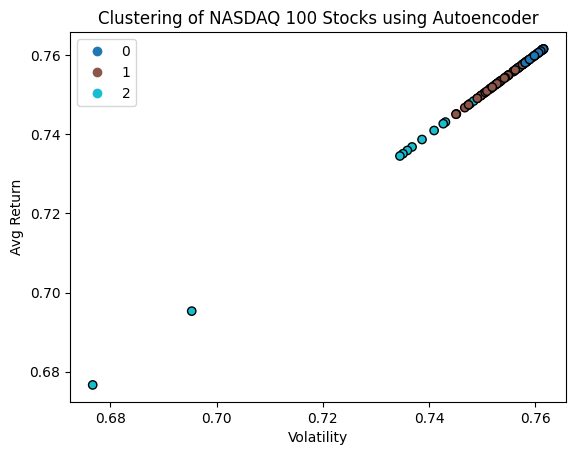

In [97]:
encoder = tf.keras.Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
embeddings = encoder.predict(input_data)

embeddings_reshaped = embeddings.reshape((embeddings.shape[0], -1))

cluster_colors = {0: 'red', 1: 'blue', 2: 'green'}
# Apply K-means clustering to the embeddings
num_clusters = 3
kmeans = KMeans(n_init=10, n_clusters=num_clusters, random_state=42)
Clusters = kmeans.fit_predict(embeddings_reshaped)

scatter = plt.scatter(embeddings_reshaped[:, 0], embeddings_reshaped[:, 0], c=Clusters, cmap='tab10', edgecolors='black')
plt.xlabel('Volatility')
plt.ylabel('Avg Return')
plt.title('Clustering of NASDAQ 100 Stocks using Autoencoder')

plt.legend(handles=scatter.legend_elements()[0], labels=cluster_colors.keys())

plt.show()


In [90]:
company_names = nasdaq100_data.columns.levels[0]

In [91]:
empty_columns
# Dropped companies ABNB, CEG, DASH, GEHC, GFS

Index(['ABNB', 'CEG', 'DASH', 'GEHC', 'GFS'], dtype='object')

In [58]:
companies_to_remove = ['ABNB', 'CEG', 'DASH', 'GEHC', 'GFS']
nasdaq100_data.drop(companies_to_remove, axis=1, level=0, inplace=True)


In [102]:
companies_cleaned = df.columns.difference(empty_columns)
len(companies_cleaned)

96

In [103]:
Clusters = pd.DataFrame(Clusters, columns=['Cluster'])
Clusters.set_index(companies_cleaned, inplace=True)
Clusters

,Cluster
AAPL,1
ADBE,1
ADI,1
ADP,0
ADSK,0
...,...
WBA,0
WBD,0
WDAY,0
XEL,0


In [104]:
Cluster_0 = [] # High Risk
Cluster_1 = [] # Medium Risk
Cluster_2 = [] # Low Risk

for i in range(len(Clusters)):
    if Clusters.iloc[i, 0] == 0:
        Cluster_0.append(Clusters.index[i])
    elif Clusters.iloc[i, 0] == 1:
        Cluster_1.append(Clusters.index[i])
    else:
        Cluster_2.append(Clusters.index[i])

print(Cluster_0)
print(Cluster_1)
print(Cluster_2)

['ADP', 'ADSK', 'AEP', 'BIIB', 'BKNG', 'BKR', 'CCEP', 'CMCSA', 'COST', 'CTSH', 'FTNT', 'KLAC', 'LRCX', 'MCHP', 'MRVL', 'PDD', 'ROP', 'ROST', 'TMUS', 'TXN', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY', 'XEL', 'ZS']
['AAPL', 'ADBE', 'ADI', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'ANSS', 'ASML', 'AVGO', 'AZN', 'CDNS', 'CDW', 'CHTR', 'CPRT', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'DDOG', 'DLTR', 'EA', 'EXC', 'FANG', 'FAST', 'GILD', 'GOOGL', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KHC', 'LULU', 'MAR', 'MDB', 'MDLZ', 'MELI', 'META', 'MRNA', 'NXPI', 'ODFL', 'PANW', 'PAYX', 'PCAR', 'PEP', 'PYPL', 'QCOM', 'REGN', 'SBUX', 'SIRI', 'SNPS', 'SPLK', 'TEAM', 'TSLA', 'TTD']
['DXCM', 'GOOG', 'KDP', 'MNST', 'MSFT', 'MU', 'NFLX', 'NVDA', 'ON', 'ORLY', 'TTWO']


In [105]:
select_company = 'AAPL'
if select_company in Cluster_0:
    print('High Risk')
elif select_company in Cluster_1:
    print('Medium Risk')
elif select_company in Cluster_2:
    print('Low Risk')
else:
    print('Company not found')

Medium Risk


Average Return - Clustering

In [110]:
# Getting only 'Adj Close' column for each company

df = pd.DataFrame()

# Loop through each company
for company in nasdaq100_data.columns.levels[0]:
    company_data = nasdaq100_data[company]

    # Calculate daily returns, volatility, and average return for each company
    daily_returns = company_data['Adj Close'].pct_change()
    volatility = daily_returns.rolling(window=20).std()
    # average_return = daily_returns.rolling(window=20).mean()

    company_features = pd.DataFrame({
        # f'{company}': volatility,
        f'{company}': average_return
    })

    df = pd.concat([df, company_features], axis=1)

df = df['2010':'2020']

# ------------------------------------------------------------------

df_cleaned, empty_columns = clean_data(df)

# ---------------------------------------------------------------------

df_scaled = scale_data(df_cleaned)

# --------------------------------------------------------------

# Autoencoder architecture - Without PCT
input_dim = df_scaled.shape[0] # The number of columns in the training data which is 192
encoding_dim = 2  # Set the desired dimensionality of the embeddings

# Reshape the input data
input_data = df_scaled.reshape(df_scaled.shape[1], 1, df_scaled.shape[0])

# Print the shape of the reshaped data
print(input_data.shape)

# ----------------------------------------------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Encoder
encoder_inputs = Input(shape=(None, input_dim))
encoder = LSTM(100, return_sequences=True)(encoder_inputs)
encoder = LSTM(encoding_dim)(encoder)

# Decoder
decoder_inputs = RepeatVector(input_dim)(encoder)
decoder = LSTM(100, return_sequences=True)(decoder_inputs)
decoder_outputs = TimeDistributed(Dense(input_dim, activation='tanh'))(decoder)

# Autoencoder model
autoencoder = Model(inputs=encoder_inputs, outputs=decoder_outputs)

autoencoder.compile(optimizer=optimizer, loss='mse')

# -----------------------------------------------------------------

autoencoder.fit(input_data, input_data, epochs=50, batch_size=32, shuffle=True)
autoencoder.save('C:\\aiprojects\\gbc-projects\\DL1_Financial\\AASD4010_project\\models\\autoencoder_2_2.h5')
# ------------------------------------------------------------------



(101, 1, 2769)
Epoch 1/50
4/4 [==============================] - 26s 5s/step - loss: 0.3042
Epoch 2/50
4/4 [==============================] - 20s 5s/step - loss: 0.2817
Epoch 3/50
4/4 [==============================] - 19s 5s/step - loss: 0.1981
Epoch 4/50
4/4 [==============================] - 19s 5s/step - loss: 0.0483
Epoch 5/50
4/4 [==============================] - 20s 5s/step - loss: 0.0199
Epoch 6/50
4/4 [==============================] - 20s 5s/step - loss: 0.0270
Epoch 7/50
4/4 [==============================] - 21s 5s/step - loss: 0.0171
Epoch 8/50
4/4 [==============================] - 20s 5s/step - loss: 0.0087
Epoch 9/50
4/4 [==============================] - 21s 5s/step - loss: 0.0095
Epoch 10/50
4/4 [==============================] - 21s 5s/step - loss: 0.0104
Epoch 11/50
4/4 [==============================] - 21s 5s/step - loss: 0.0084
Epoch 12/50
4/4 [==============================] - 20s 5s/step - loss: 0.0068
Epoch 13/50
4/4 [==============================] - 21s 5s/

c:\aiprojects\aienv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 8ms/step


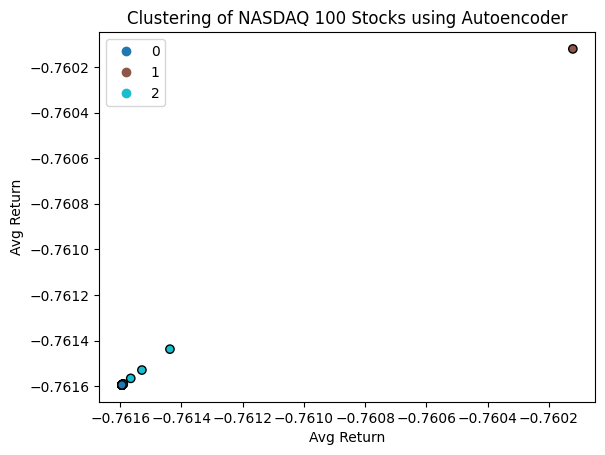

In [111]:
encoder = tf.keras.Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
embeddings = encoder.predict(input_data)

embeddings_reshaped = embeddings.reshape((embeddings.shape[0], -1))

cluster_colors = {0: 'red', 1: 'blue', 2: 'green'}
# Apply K-means clustering to the embeddings
num_clusters = 3
kmeans = KMeans(n_init=10, n_clusters=num_clusters, random_state=42)
Clusters = kmeans.fit_predict(embeddings_reshaped)

scatter = plt.scatter(embeddings_reshaped[:, 0], embeddings_reshaped[:, 0], c=Clusters, cmap='tab10', edgecolors='black')
plt.xlabel('Avg Return')
plt.ylabel('Avg Return')
plt.title('Clustering of NASDAQ 100 Stocks using Autoencoder')

plt.legend(handles=scatter.legend_elements()[0], labels=cluster_colors.keys())

plt.show()

# --------------------------------------------


In [112]:
companies_cleaned = df.columns.difference(empty_columns)

# ----------------------------------------------

Clusters = pd.DataFrame(Clusters, columns=['Cluster'])
Clusters.set_index(companies_cleaned, inplace=True)
Clusters

# -----------------------------------------------------------------

Cluster_0_2 = [] # Low Return
Cluster_1_2 = [] # Medium Return
Cluster_2_2 = [] # High Return

for i in range(len(Clusters)):
    if Clusters.iloc[i, 0] == 0:
        Cluster_0_2.append(Clusters.index[i])
    elif Clusters.iloc[i, 0] == 1:
        Cluster_1_2.append(Clusters.index[i])
    else:
        Cluster_2_2.append(Clusters.index[i])

print(Cluster_0_2)
print(Cluster_1_2)
print(Cluster_2_2)

# --------------------------------------------------------------------

select_company = 'AAPL'
if select_company in Cluster_0_2:
    print('Low Return')
elif select_company in Cluster_1_2:
    print('Medium Return')
elif select_company in Cluster_2_2:
    print('High Return')
else:
    print('Company not found')

['AAPL', 'ABNB', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'ANSS', 'ASML', 'AVGO', 'AZN', 'BIIB', 'BKNG', 'BKR', 'CCEP', 'CDNS', 'CDW', 'CEG', 'CHTR', 'CMCSA', 'COST', 'CPRT', 'CRWD', 'CSCO', 'CSGP', 'CSX', 'CTAS', 'CTSH', 'DASH', 'DDOG', 'DLTR', 'DXCM', 'EA', 'EXC', 'FANG', 'FAST', 'FTNT', 'GEHC', 'GFS', 'GILD', 'GOOG', 'GOOGL', 'HON', 'IDXX', 'ILMN', 'INTC', 'INTU', 'ISRG', 'KDP', 'KHC', 'KLAC', 'LRCX', 'LULU', 'MAR', 'MCHP', 'MDB', 'MDLZ', 'MELI', 'META', 'MNST', 'MRNA', 'MRVL', 'MSFT', 'MU', 'NFLX', 'NVDA', 'NXPI', 'ODFL', 'ON', 'ORLY', 'PANW', 'PAYX', 'PCAR', 'PDD', 'PEP', 'PYPL', 'REGN', 'ROP', 'ROST', 'SBUX', 'SIRI', 'SNPS', 'SPLK', 'TSLA', 'TTD', 'TTWO', 'VRSK', 'VRTX', 'WBA', 'WBD', 'WDAY', 'XEL', 'ZS']
['TMUS']
['QCOM', 'TEAM', 'TXN']
Low Return


Combine Result

In [117]:
select_company = 'AVGO'

print("Company Name: ", select_company)

if select_company in Cluster_0:
    print('High Risk')
elif select_company in Cluster_1:
    print('Medium Risk')
elif select_company in Cluster_2:
    print('Low Risk')
else:
    print('Company not found')

if select_company in Cluster_0_2:
    print('Low Return')
elif select_company in Cluster_1_2:
    print('Medium Return')
elif select_company in Cluster_2_2:
    print('High Return')
else:
    print('Company not found')

Company Name:  AVGO
Medium Risk
Low Return
